In [1]:
import geopandas as gpd

In [2]:
gdf_2020 = gpd.read_file("../assets/data/2020population_4326.geojson")
cen_2020 = gdf_2020[["GEOID_20", "TOTAL_POPULATION","ACRES_LAND","geometry"]]
cen_2020.head(3)

,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5..."
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5..."
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5..."


In [3]:
blocks = gpd.read_file("../assets/data/census_cleaned.geojson")
blocks.head(3)

,TRACT_NUMB,POP2025,PCPOP_FROM_20,XCOORD,YCOORD,GEOID_20,POP2010,POP2020,NAME,10YR_GROWTH_PCT,5YR_GROWTH_PCT,POP2030,avg_annual_growth_rate,geometry
0,3601,0.000,0.0000,1.191952e+06,859163.429140,530330036011002,0.000,0.000,Block 1002,NaN,NaN,NaN,NaN,"POLYGON ((-122.32055 47.67516, -122.32046 47.6..."
1,11401,72.519,8.5191,1.181305e+06,806209.740690,530330114013007,69.996,66.826,Block 3007,-4.528830,8.519139,63.799564,0.236349,"POLYGON ((-122.3591 47.53008, -122.35775 47.53..."
2,4402,77.506,-1.3617,1.193554e+06,856936.788986,530330044022009,81.995,78.576,Block 2009,-4.169766,-1.361739,75.299564,-0.374649,"POLYGON ((-122.31416 47.66944, -122.31302 47.6..."


In [4]:
bg_pop25 = blocks["POP2025"]
bg_growth = blocks["avg_annual_growth_rate"]
bg_growth.head()
bg_growth.describe()


count    8388.000000
mean       -0.867473
std        15.214333
min      -100.000000
25%        -0.555890
50%         0.489146
75%         1.709001
max       112.005503
Name: avg_annual_growth_rate, dtype: float64

In [5]:
null_count = bg_growth.isna().sum()
print(f"Number of null values in avg_annual_growth_rate: {null_count}")

Number of null values in avg_annual_growth_rate: 1905


In [6]:
citywide_avg = 0.015
bg_growth = bg_growth.fillna(citywide_avg)

In [7]:
bg_growth.isna().sum()

np.int64(0)

In [8]:
bg_centroids = blocks.copy()
bg_centroids["geometry"] = bg_centroids.centroid
joined = gpd.sjoin(bg_centroids, cen_2020, how="left", predicate="within")
print(f"\nJoined Records: {len(joined)}")
print(f"Block groups matched: {joined['index_right'].notna().sum()}")
joined.head(3)


Joined Records: 10293
Block groups matched: 9998


/var/folders/83/l6gh4cqs37q8z5mdrz9b_kkh0000gn/T/ipykernel_32301/2974143461.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bg_centroids["geometry"] = bg_centroids.centroid


,TRACT_NUMB,POP2025,PCPOP_FROM_20,XCOORD,YCOORD,GEOID_20_left,POP2010,POP2020,NAME,10YR_GROWTH_PCT,5YR_GROWTH_PCT,POP2030,avg_annual_growth_rate,geometry,index_right,GEOID_20_right,TOTAL_POPULATION,ACRES_LAND
0,3601,0.000,0.0000,1.191952e+06,859163.429140,530330036011002,0.000,0.000,Block 1002,NaN,NaN,NaN,NaN,POINT (-122.3203 47.67498),192.0,530330036011,1099.0,60.733066
1,11401,72.519,8.5191,1.181305e+06,806209.740690,530330114013007,69.996,66.826,Block 3007,-4.528830,8.519139,63.799564,0.236349,POINT (-122.35843 47.52918),411.0,530330114013,1678.0,123.698977
2,4402,77.506,-1.3617,1.193554e+06,856936.788986,530330044022009,81.995,78.576,Block 2009,-4.169766,-1.361739,75.299564,-0.374649,POINT (-122.31359 47.66898),244.0,530330044022,907.0,31.889938


In [9]:
import numpy as np

In [10]:
tract_pop_2025 = joined.groupby('index_right')['POP2025'].sum().reset_index()
tract_pop_2025.columns = ['tract_idx', 'pop25']
tract_pop_2025.head()

,tract_idx,pop25
0,0.0,1523.426
1,1.0,1226.314
2,2.0,1257.337
3,3.0,1073.152
4,4.0,1391.135


In [11]:
joined.columns.tolist()

['TRACT_NUMB',
 'POP2025',
 'PCPOP_FROM_20',
 'XCOORD',
 'YCOORD',
 'GEOID_20_left',
 'POP2010',
 'POP2020',
 'NAME',
 '10YR_GROWTH_PCT',
 '5YR_GROWTH_PCT',
 'POP2030',
 'avg_annual_growth_rate',
 'geometry',
 'index_right',
 'GEOID_20_right',
 'TOTAL_POPULATION',
 'ACRES_LAND']

In [12]:
def weight_avg(group):
    pop = group['POP2025'].fillna(0)
    growth = group['avg_annual_growth_rate']
    total_pop = pop.sum()
    if total_pop == 0:
        return growth.mean()
    return (pop*growth).sum() / total_pop
tract_growth = joined.groupby('index_right').apply(weight_avg).reset_index()
tract_growth.columns = ['tract_idx', 'avg_annual_growth_rate']
tract_growth.head()

/var/folders/83/l6gh4cqs37q8z5mdrz9b_kkh0000gn/T/ipykernel_32301/204177122.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tract_growth = joined.groupby('index_right').apply(weight_avg).reset_index()


,tract_idx,avg_annual_growth_rate
0,0.0,0.523903
1,1.0,0.633438
2,2.0,1.446091
3,3.0,-0.863269
4,4.0,1.003481


In [13]:
tract_stats = tract_pop_2025.merge(tract_growth, on='tract_idx', how='outer')
print (f"\nTracts with data: {len(tract_stats)}")
print(tract_stats.head(3))


Tracts with data: 536
   tract_idx     pop25  avg_annual_growth_rate
0        0.0  1523.426                0.523903
1        1.0  1226.314                0.633438
2        2.0  1257.337                1.446091


In [14]:
cen_2020 = cen_2020.reset_index(drop=True)
cen_2020['tract_idx'] = cen_2020.index
cen_2020.head(3)


,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry,tract_idx
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5...",0
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5...",1
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5...",2


In [15]:
result = cen_2020.merge(tract_stats, on='tract_idx', how='left')
result.head(3)

,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry,tract_idx,pop25,avg_annual_growth_rate
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5...",0,1523.426,0.523903
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5...",1,1226.314,0.633438
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5...",2,1257.337,1.446091


In [16]:
result['pop25'] = result['pop25'].fillna(0).astype(int)
result['avg_annual_growth_rate'] = result['avg_annual_growth_rate'].fillna(citywide_avg)
result.head()
result.describe()

,TOTAL_POPULATION,ACRES_LAND,tract_idx,pop25,avg_annual_growth_rate
count,536.000000,536.000000,536.000000,536.000000,536.000000
mean,1385.169776,100.664202,267.500000,1520.115672,2.746785
std,348.868745,119.057063,154.874142,486.143898,4.256522
min,276.000000,6.845066,0.000000,131.000000,-2.921412
25%,1144.750000,45.938373,133.750000,1270.750000,0.716143
50%,1350.500000,78.958077,267.500000,1433.500000,1.366744
75%,1601.250000,115.346939,401.250000,1641.750000,3.129819
max,2745.000000,1595.352128,535.000000,5464.000000,54.178251


In [17]:
from scipy.stats.mstats import winsorize
result['avg_annual_growth_rate_winsorized'] = winsorize(result['avg_annual_growth_rate'], limits=[0.03, 0.05])
result.head()

,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry,tract_idx,pop25,avg_annual_growth_rate,avg_annual_growth_rate_winsorized
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5...",0,1523,0.523903,0.523903
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5...",1,1226,0.633438,0.633438
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5...",2,1257,1.446091,1.446091
3,530330107012,954,98.666214,"POLYGON ((-122.36302 47.55011, -122.36306 47.5...",3,1073,-0.033498,-0.033498
4,530330111021,1850,160.180380,"POLYGON ((-122.25754 47.54493, -122.25754 47.5...",4,1391,1.003481,1.003481


In [18]:
result = result.rename(columns = {'avg_annual_growth_rate_winsorized': 'avg_growth'})
result.head()

,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry,tract_idx,pop25,avg_annual_growth_rate,avg_growth
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5...",0,1523,0.523903,0.523903
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5...",1,1226,0.633438,0.633438
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5...",2,1257,1.446091,1.446091
3,530330107012,954,98.666214,"POLYGON ((-122.36302 47.55011, -122.36306 47.5...",3,1073,-0.033498,-0.033498
4,530330111021,1850,160.180380,"POLYGON ((-122.25754 47.54493, -122.25754 47.5...",4,1391,1.003481,1.003481


In [20]:
result['avg_growth_pct'] = result['avg_growth'] / 100
result['avg_growth_pct'] = result['avg_growth_pct'].clip(upper=0.03)
result['avg_growth_pct'] = result['avg_growth_pct'].clip(lower=-0.02)
result.head()

,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry,tract_idx,pop25,avg_annual_growth_rate,avg_growth,avg_growth_pct
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5...",0,1523,0.523903,0.523903,0.005239
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5...",1,1226,0.633438,0.633438,0.006334
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5...",2,1257,1.446091,1.446091,0.014461
3,530330107012,954,98.666214,"POLYGON ((-122.36302 47.55011, -122.36306 47.5...",3,1073,-0.033498,-0.033498,-0.000335
4,530330111021,1850,160.180380,"POLYGON ((-122.25754 47.54493, -122.25754 47.5...",4,1391,1.003481,1.003481,0.010035


In [21]:
result['pop50'] = result['TOTAL_POPULATION'] * (1 + result['avg_growth_pct'])**30
result['pop50'] = result['pop50'].astype(int)
result.head()

,GEOID_20,TOTAL_POPULATION,ACRES_LAND,geometry,tract_idx,pop25,avg_annual_growth_rate,avg_growth,avg_growth_pct,pop50
0,530330105012,1380,88.852670,"POLYGON ((-122.37625 47.55928, -122.37625 47.5...",0,1523,0.523903,0.523903,0.005239,1614
1,530330105022,1982,93.418437,"POLYGON ((-122.39004 47.55713, -122.39005 47.5...",1,1226,0.633438,0.633438,0.006334,2395
2,530330106023,1164,74.934707,"POLYGON ((-122.38705 47.55212, -122.38711 47.5...",2,1257,1.446091,1.446091,0.014461,1790
3,530330107012,954,98.666214,"POLYGON ((-122.36302 47.55011, -122.36306 47.5...",3,1073,-0.033498,-0.033498,-0.000335,944
4,530330111021,1850,160.180380,"POLYGON ((-122.25754 47.54493, -122.25754 47.5...",4,1391,1.003481,1.003481,0.010035,2496


In [22]:
outliers = (result['avg_growth_pct'] == 0.03)
print(f"Number of capped growth rates: {outliers.sum()}")

Number of capped growth rates: 142


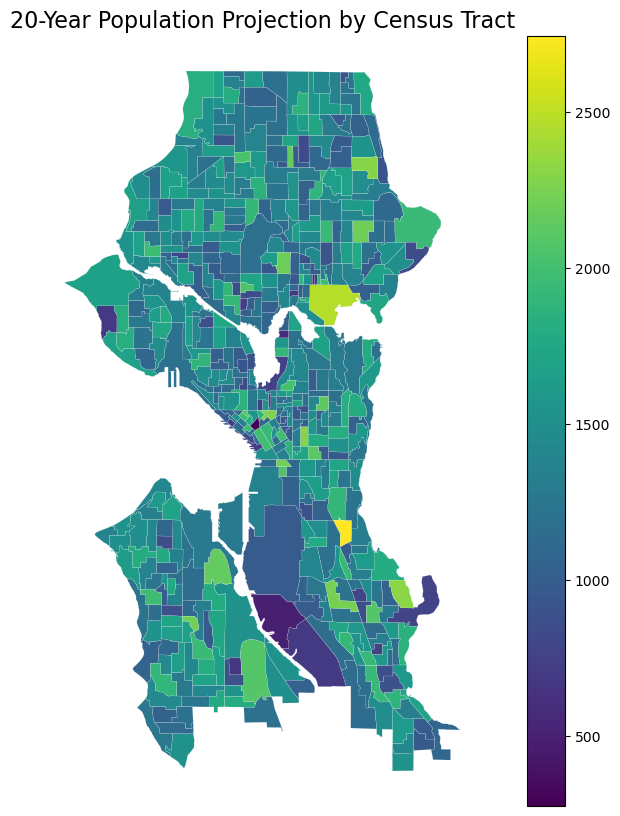

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

result.plot(
    column="TOTAL_POPULATION",    # the column you want to map
    cmap="viridis",            # color scheme
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax
)

ax.set_title("20-Year Population Projection by Census Tract", fontsize=16)
ax.axis("off")

plt.show()

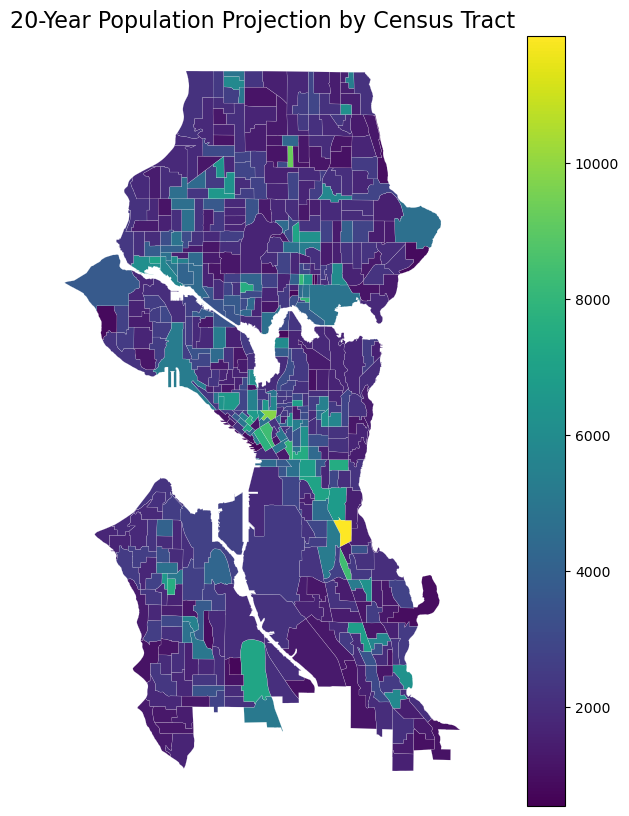

In [ ]:

import matplotlib.pyplot as plt
# Make a simple choropleth
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

result.plot(
    column="pop50",    # the column you want to map
    cmap="viridis",            # color scheme
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax
)

ax.set_title("20-Year Population Projection by Census Tract", fontsize=16)
ax.axis("off")

plt.show()


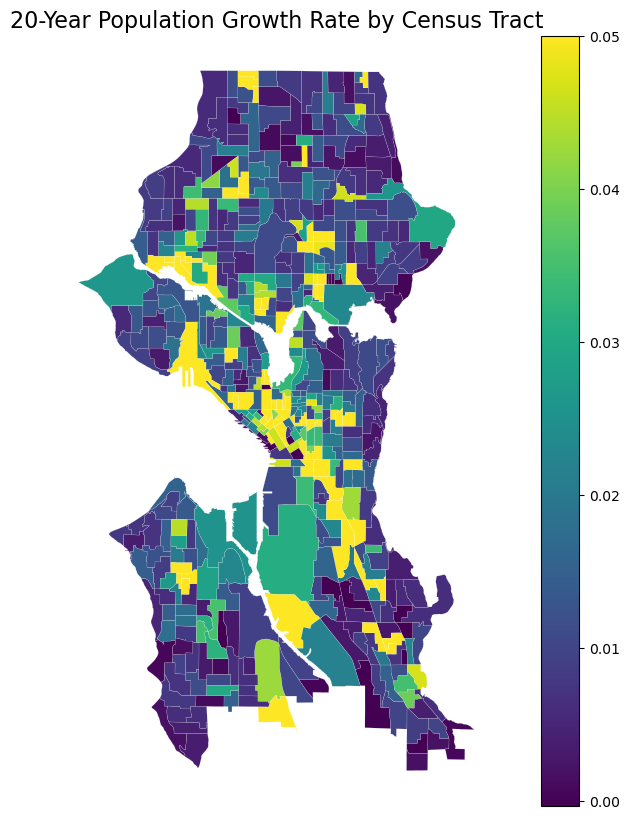

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

result.plot(
    column="avg_growth_pct",    # the column you want to map
    cmap="viridis",            # color scheme
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax
)

ax.set_title("20-Year Population Growth Rate by Census Tract", fontsize=16)
ax.axis("off")

plt.show()

In [25]:
total2050 = result['pop50'].sum()
total2020 = result['TOTAL_POPULATION'].sum()
print(f"Total 2020 Population: {total2020}")
print(f"Total 2050 Population: {total2050}")

Total 2020 Population: 742451
Total 2050 Population: 1257004


In [26]:
result.to_file("../assets/data/census_full.geojson", driver="GeoJSON")